In [37]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../scripts")
import preprocessing_census_blocks
from ast import literal_eval
import glob
import os

In [8]:
# loading and census blocks
blocks_df = pd.read_csv("../data/blocks_patches_relation.csv")
blocks_df["mhi"] = blocks_df["mhi"].apply(lambda x: np.nan if x < 0 else x)
blocks_df["patches_relation"] = blocks_df["patches_relation"].apply(lambda x : np.nan if x == "{}" else x)
blocks_df.isna().mean()

Unnamed: 0          0.000000
state               0.000000
county              0.000000
tract               0.000000
block group         0.000000
pop                 0.149135
mhi                 0.219141
year                0.149135
ed_attain           0.161526
area                0.000000
density             0.149135
patches_relation    0.000530
dtype: float64

In [11]:
blocks_df = blocks_df.dropna()
print(f"Total of {blocks_df.shape[0]} blocks")

Total of 54477 blocks


In [20]:
blocks_geo_df = gpd.read_file("../data/census_blocks.geojson")
for col in ["state", "county", "tract", "block group"]:
    blocks_geo_df[col] = blocks_geo_df[col].astype(int)
blocks_df = blocks_df.merge(
    blocks_geo_df,
    how="left",
    on=["state", "county", "tract", "block group"],
    suffixes=("!", ""),
)
blocks_df = blocks_df.drop(columns=[col for col in blocks_df.columns if "!" in col])
blocks_df = gpd.GeoDataFrame(blocks_df, geometry="geometry")
blocks_df = blocks_df.to_crs("EPSG:4326")

In [34]:
blocks_df["patches_relation"] = blocks_df["patches_relation"].apply(literal_eval)
blocks_df["n_patches"] = blocks_df["patches_relation"].apply(len)
blocks_df["city_state"] = blocks_df.patches_relation.apply(lambda x : list(x.keys())[0].split("/")[0])

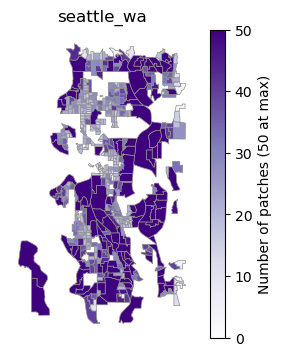

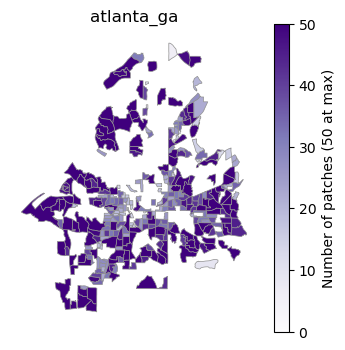

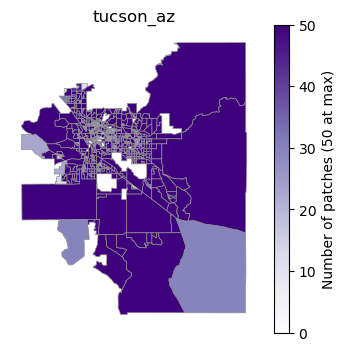

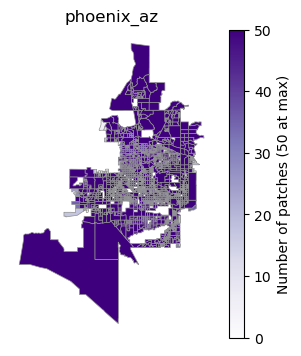

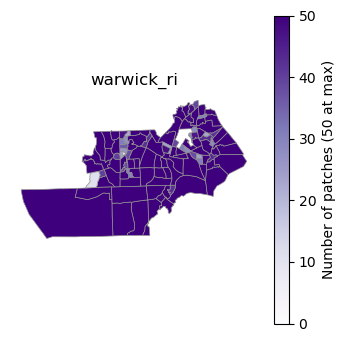

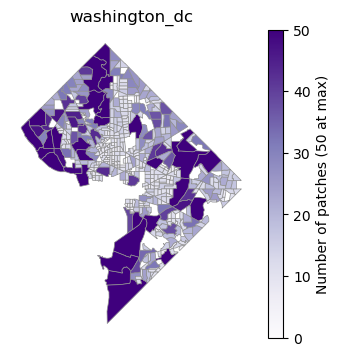

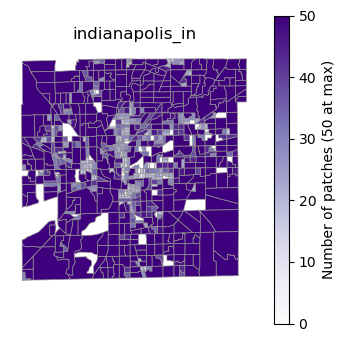

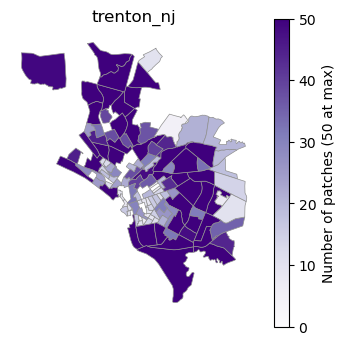

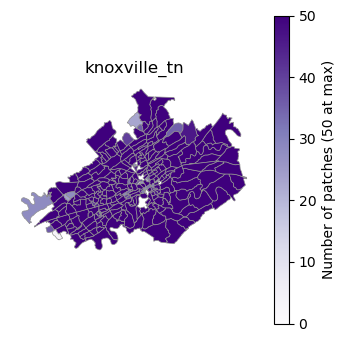

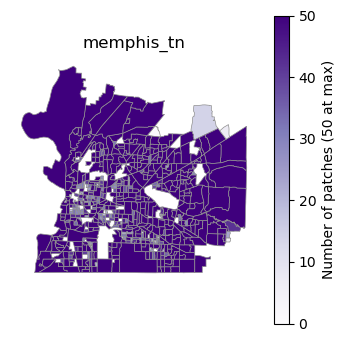

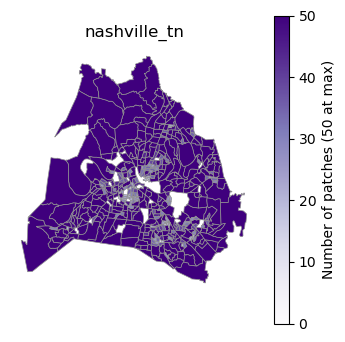

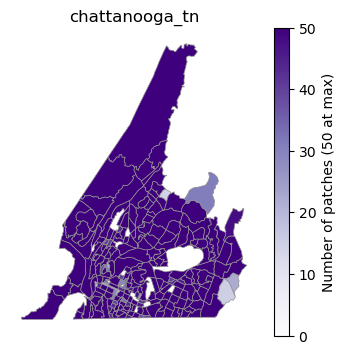

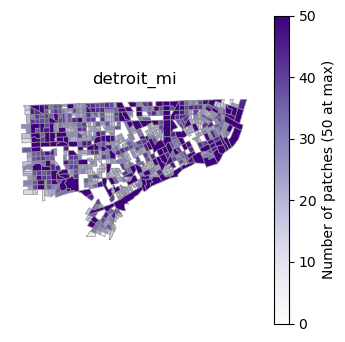

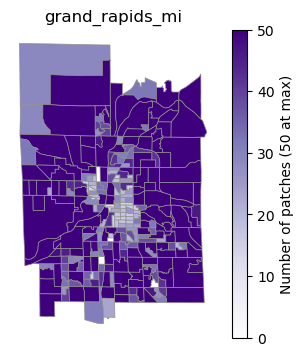

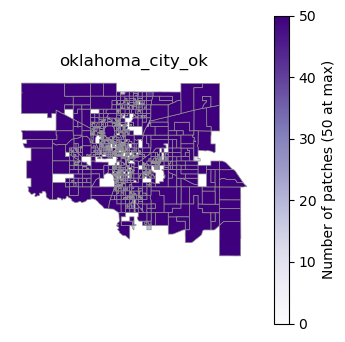

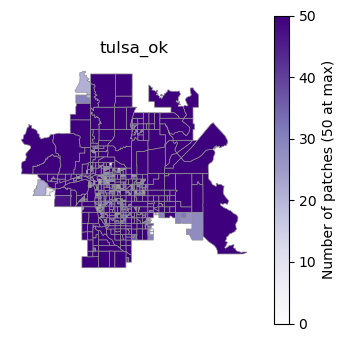

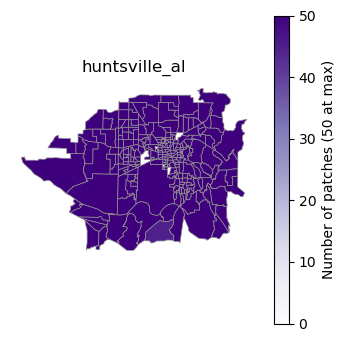

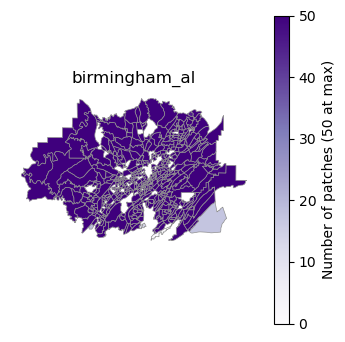

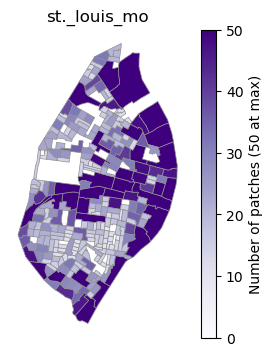

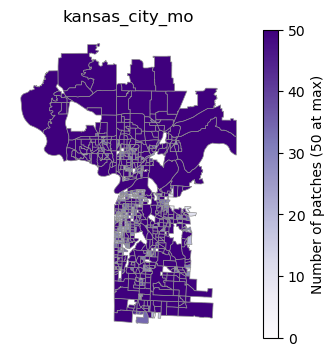

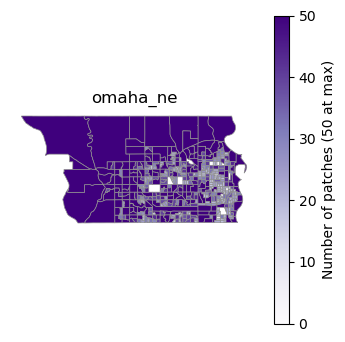

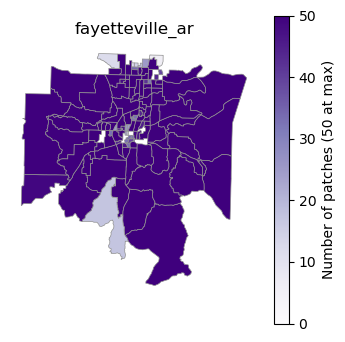

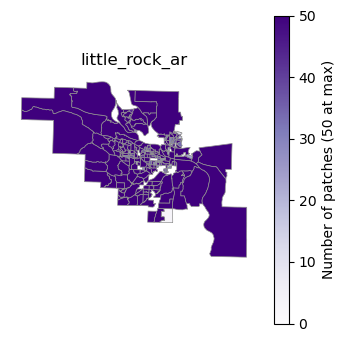

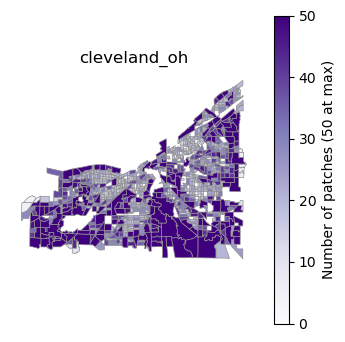

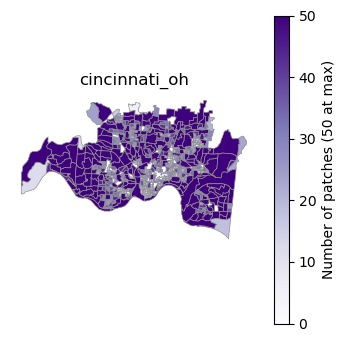

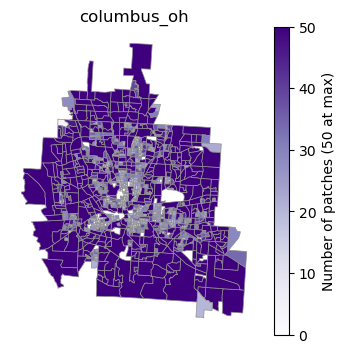

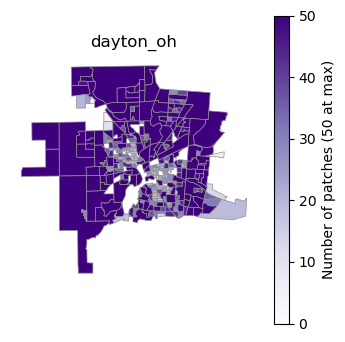

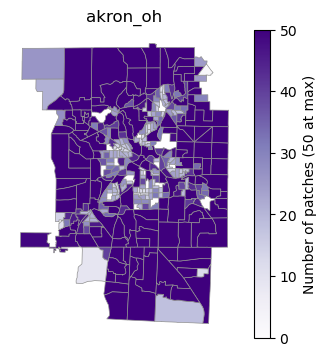

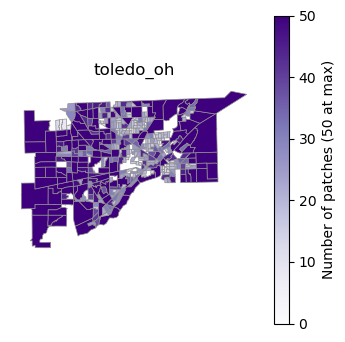

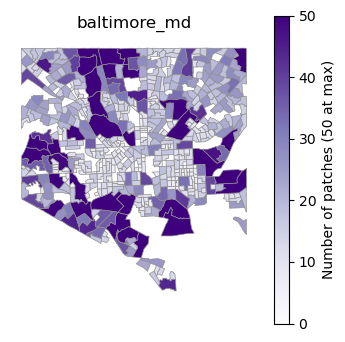

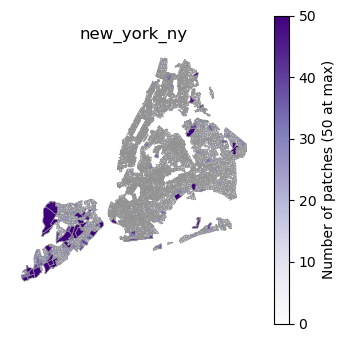

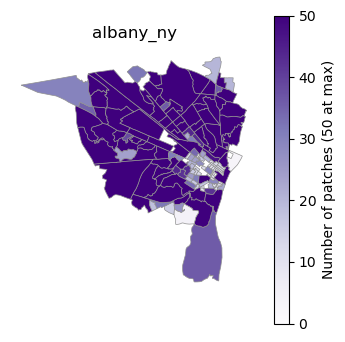

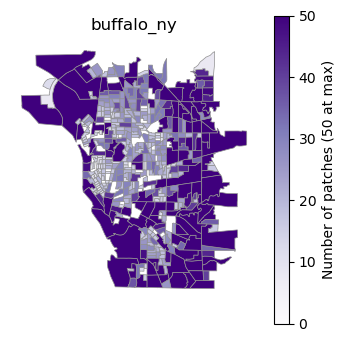

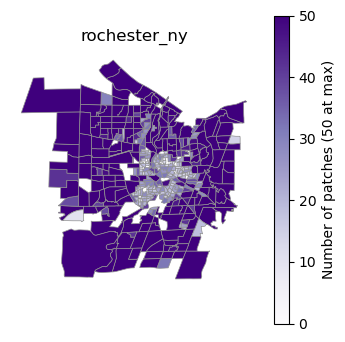

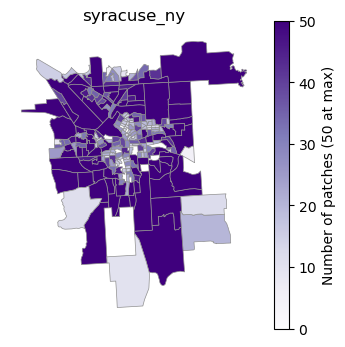

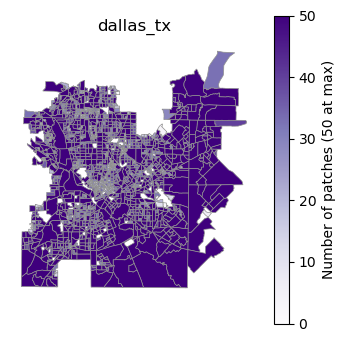

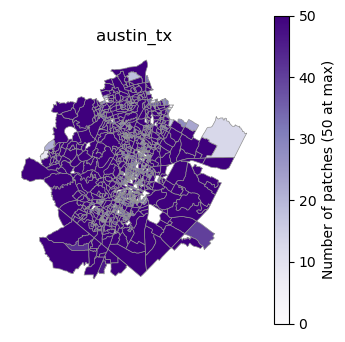

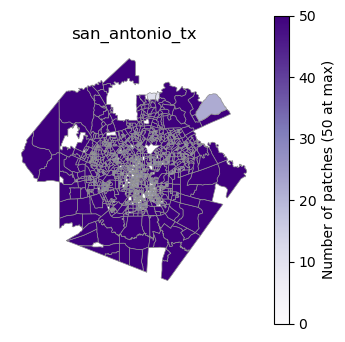

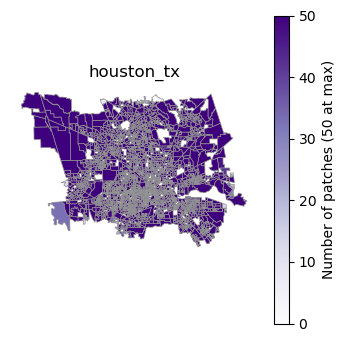

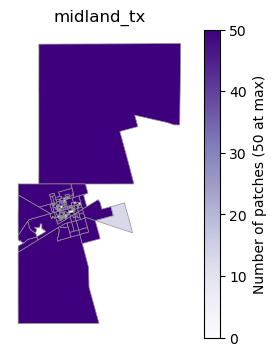

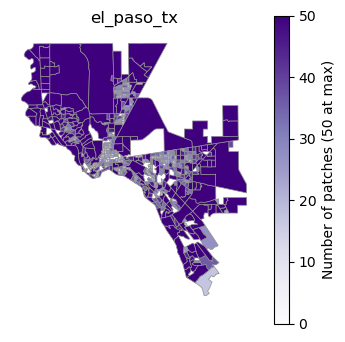

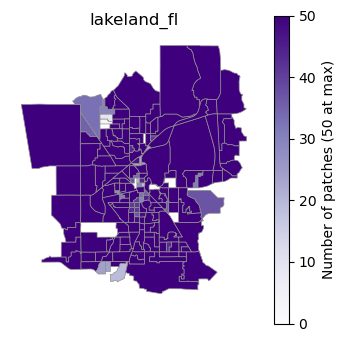

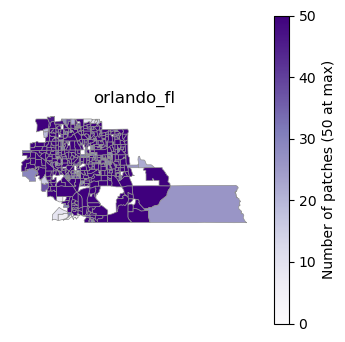

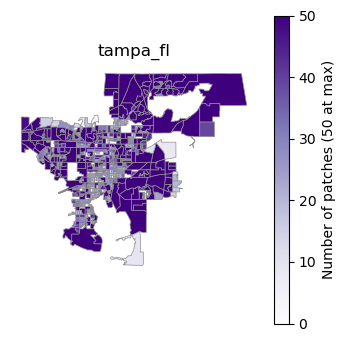

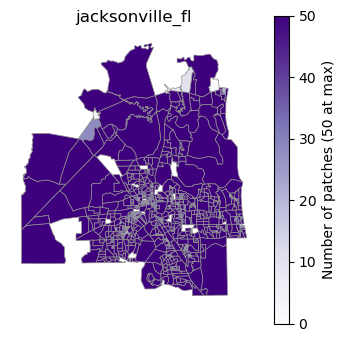

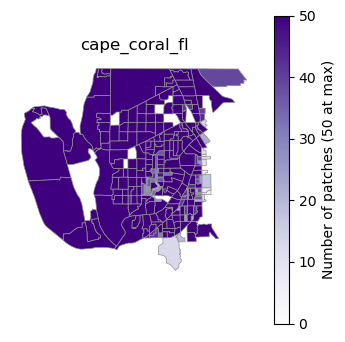

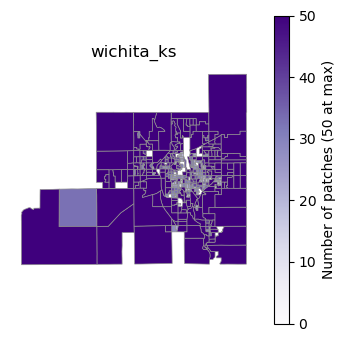

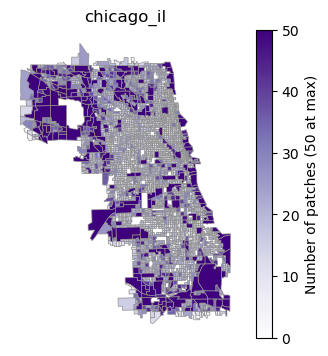

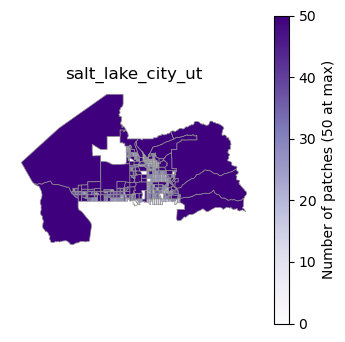

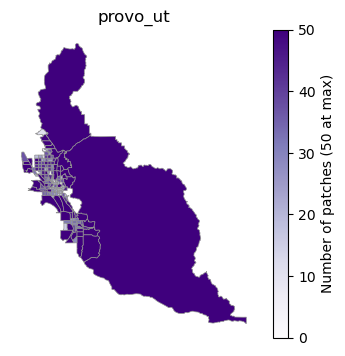

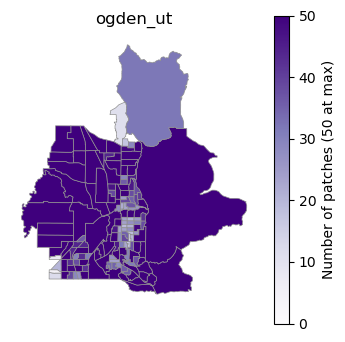

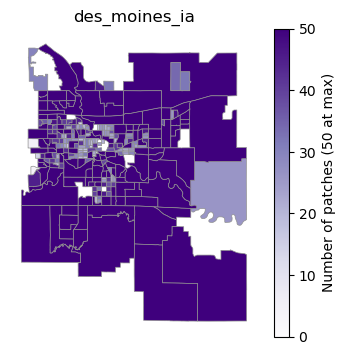

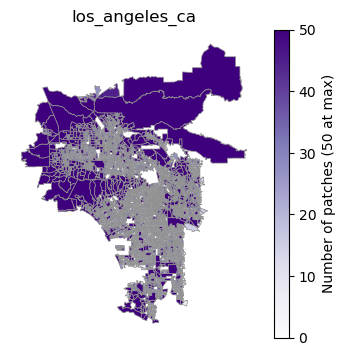

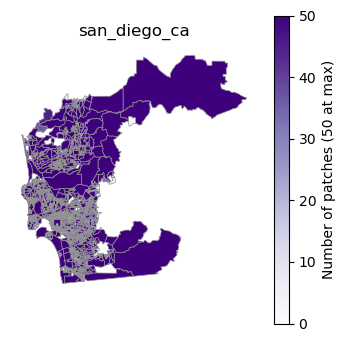

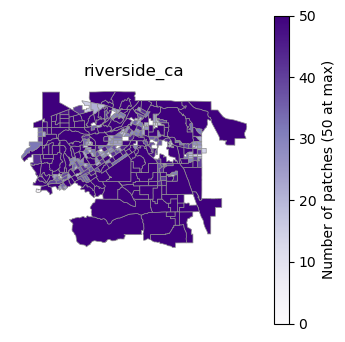

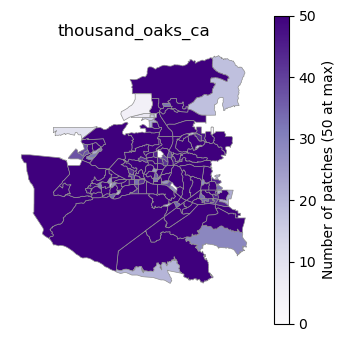

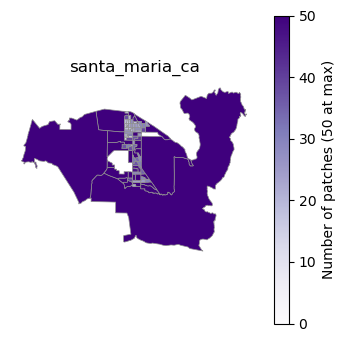

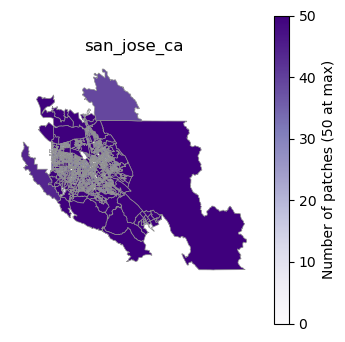

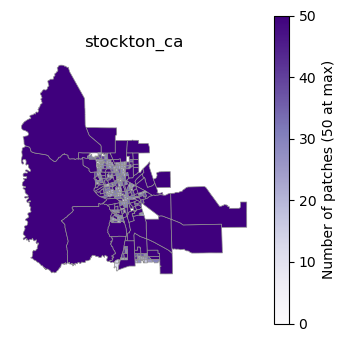

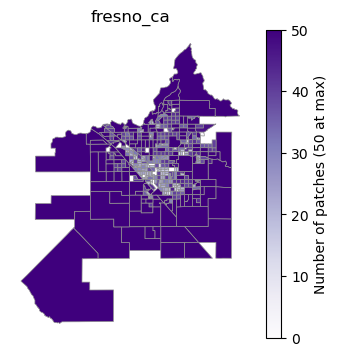

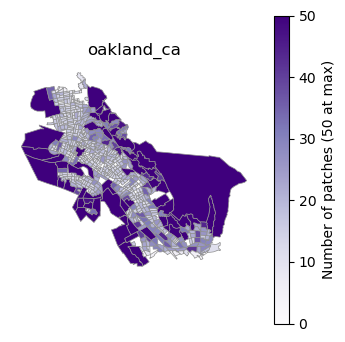

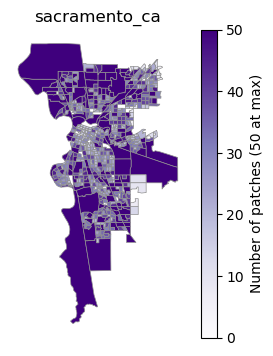

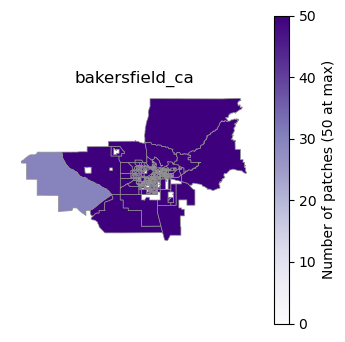

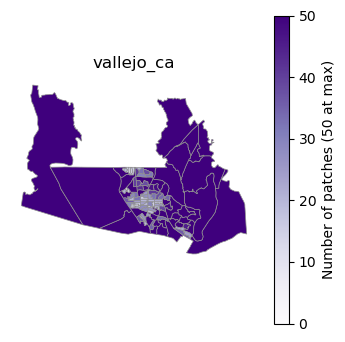

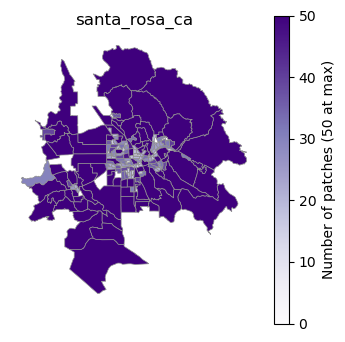

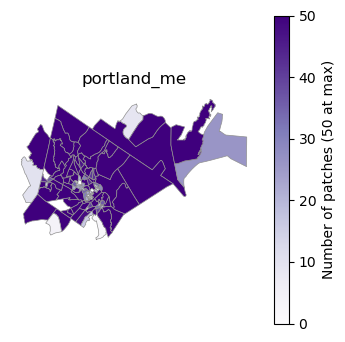

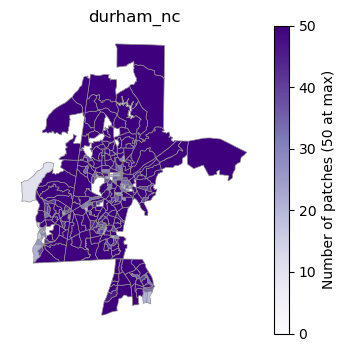

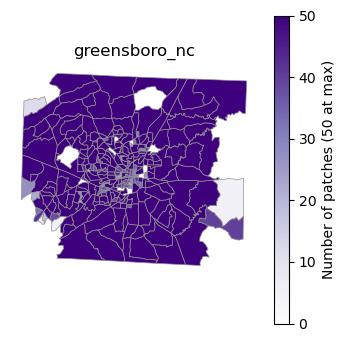

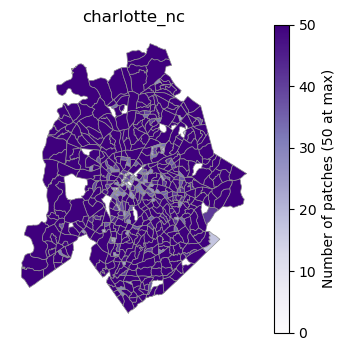

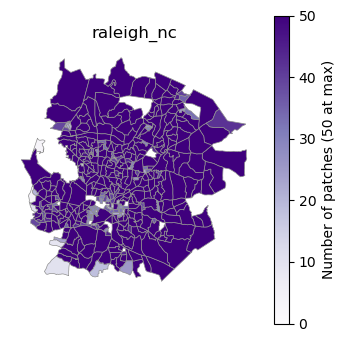

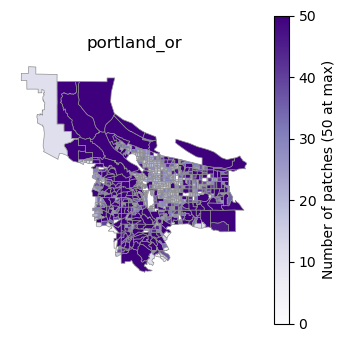

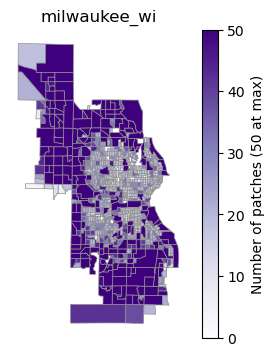

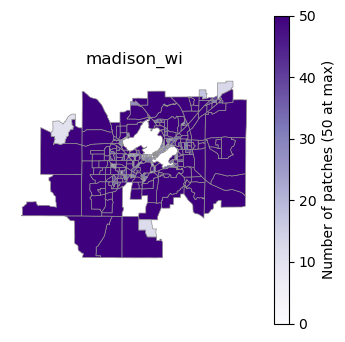

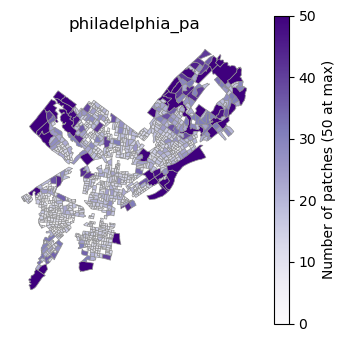

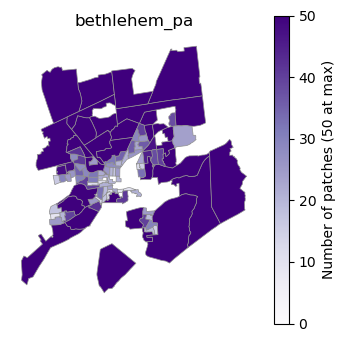

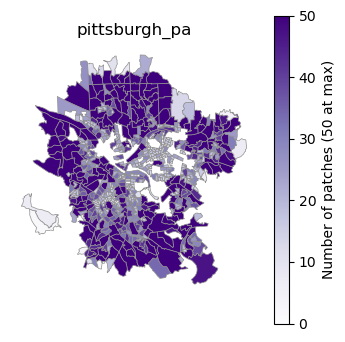

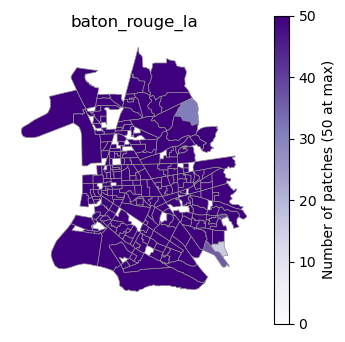

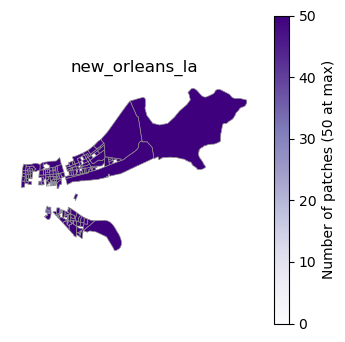

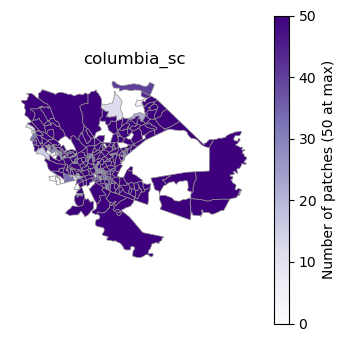

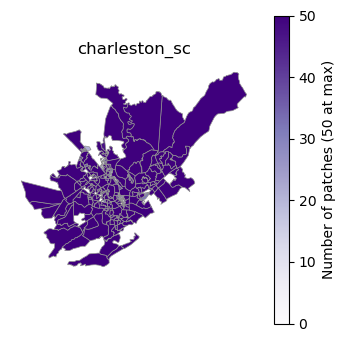

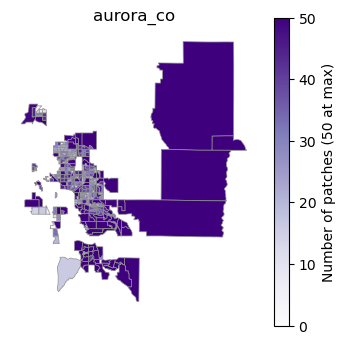

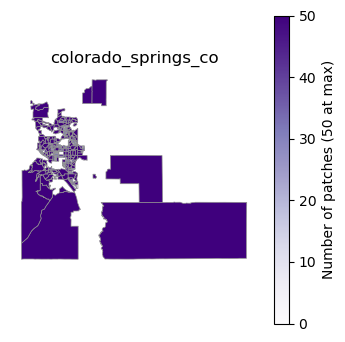

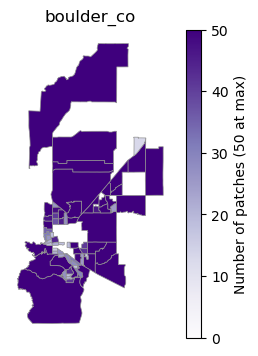

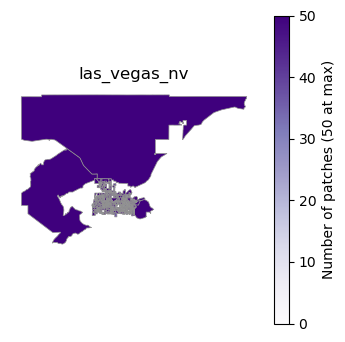

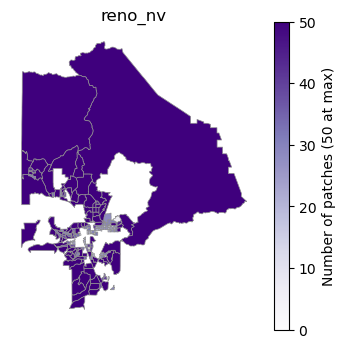

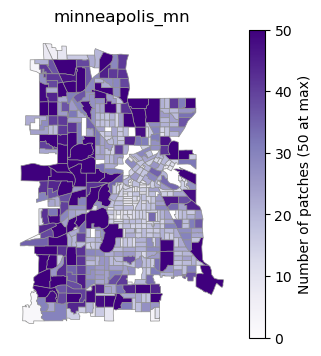

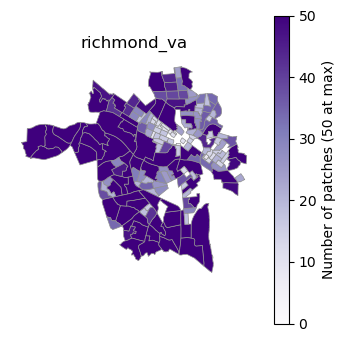

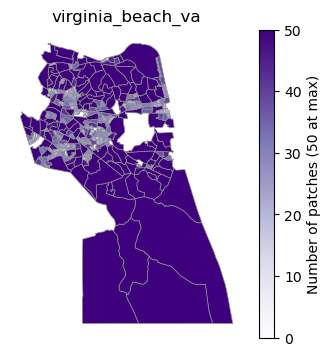

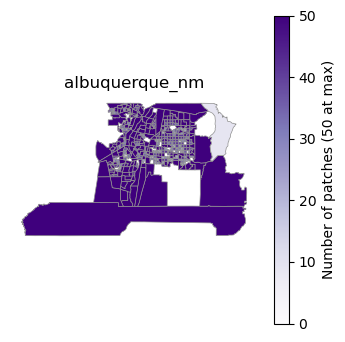

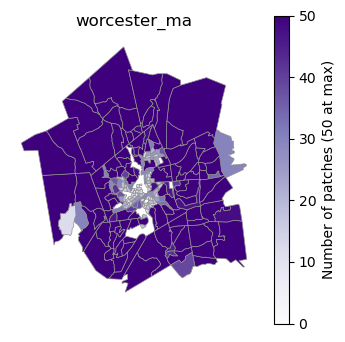

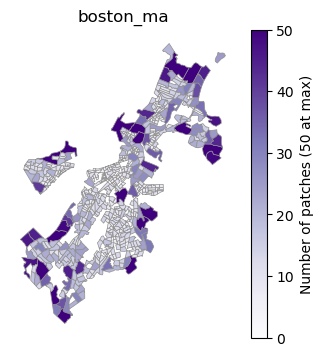

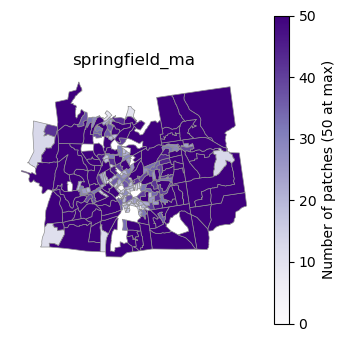

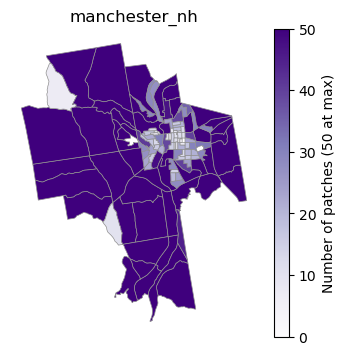

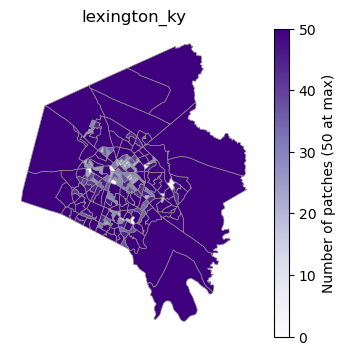

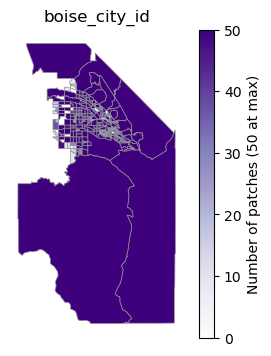

In [76]:
unique_cities = blocks_df.city_state.unique()
for city_state in unique_cities:
    fig, ax = plt.subplots(figsize=(4, 4))
    blocks_df[blocks_df.city_state == city_state].plot(
        ax=ax, 
        ec= "#909090", 
        lw = 0.5,  
        column = "n_patches", 
        cmap = "Purples",
        legend=True,
        legend_kwds={"label": "Number of patches (50 at max)"},
        vmax = 50,
        vmin = 0
        )
    plt.axis("off")
    plt.title(city_state)
    plt.show()

In [133]:
# visualing patches from a block
selected_block = blocks_df.sample(1)

In [134]:
patches_relation = selected_block.patches_relation.values[0]
city_state = selected_block.city_state.values[0]

In [135]:
filenames = patches_relation.keys()
filenames_short = [filename.split("/")[-1] for filename in filenames]

In [136]:
patches_geo_df = glob.glob(f"../data/output/patches/{city_state}/*.geojson")
patches_geo_df_list = []
for f in patches_geo_df:
    temp_df = gpd.read_file(f)
    temp_df = temp_df[temp_df.patche_filename.isin(filenames_short)]
    if temp_df.shape[0] > 0:
        patches_geo_df_list.append(temp_df)
patches_geo_df = pd.concat(patches_geo_df_list)

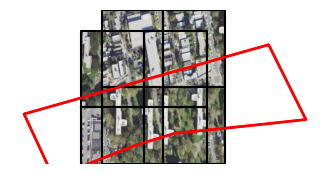

In [150]:
fig, ax = plt.subplots(figsize=(4, 4))
selected_block.plot(ax=ax, ec="red", lw=2, fc="none", zorder = 2)
for i, row in patches_geo_df.iterrows():
    img = plt.imread(f"../data/output/patches/{city_state}/{row.patche_filename}")
    xmin, ymin, xmax, ymax = row.geometry.bounds
    ax.imshow(img, extent=[xmin, xmax, ymin, ymax], zorder = 1)
    x, y = row.geometry.exterior.coords.xy
    ax.plot(x, y, color="black", zorder = 3)

x, y = selected_block.geometry.values[0].exterior.coords.xy
ax.plot(x, y, color="red", zorder = 3)
plt.axis("off")
plt.show()

In [175]:
def plot_block_images(selected_block):
    patches_relation = selected_block.patches_relation.values[0]
    city_state = selected_block.city_state.values[0]
    filenames = patches_relation.keys()
    filenames_short = [filename.split("/")[-1] for filename in filenames]
    patches_geo_df = glob.glob(f"../data/output/patches/{city_state}/*.geojson")
    patches_geo_df_list = []
    for f in patches_geo_df:
        temp_df = gpd.read_file(f)
        temp_df = temp_df[temp_df.patche_filename.isin(filenames_short)]
        if temp_df.shape[0] > 0:
            patches_geo_df_list.append(temp_df)
    patches_geo_df = pd.concat(patches_geo_df_list)
    print(f"Total of {patches_geo_df.entity_id.unique().shape[0]} scenes")
    fig, ax = plt.subplots(figsize=(6, 6))
    selected_block.plot(ax=ax, ec="red", lw=2, fc="none", zorder = 2)
    for i, row in patches_geo_df.iterrows():
        img = plt.imread(f"../data/output/patches/{city_state}/{row.patche_filename}")
        img = img.transpose(1, 0, 2)
        xmin, ymin, xmax, ymax = row.geometry.bounds
        ax.imshow(img, extent=[xmin, xmax, ymin, ymax], zorder = 1)
        x, y = row.geometry.exterior.coords.xy
        ax.plot(x, y, color="#909090", lw = 0.5, zorder = 3)

    x, y = selected_block.geometry.values[0].exterior.coords.xy
    ax.plot(x, y, color="red", zorder = 3)
    plt.axis("off")
    plt.show()

Total of 2 scenes


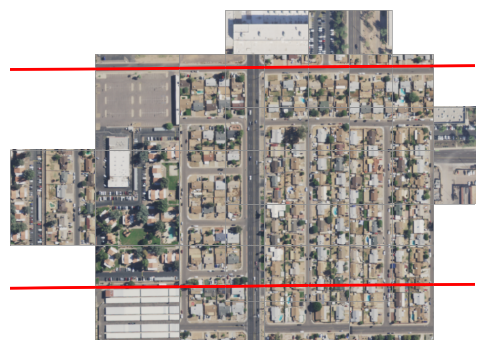

In [176]:
plot_block_images(blocks_df.head(1000).tail(1))

Total of 1 scenes


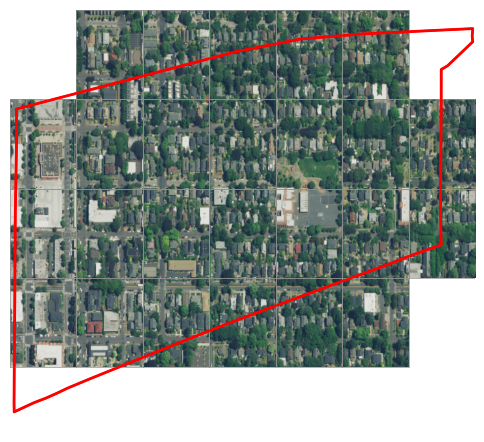

In [177]:
plot_block_images(blocks_df.sample(1))

Total of 1 scenes


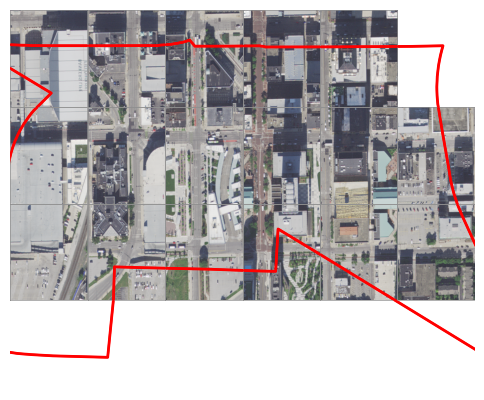

In [178]:
plot_block_images(blocks_df.sample(1))

Total of 1 scenes


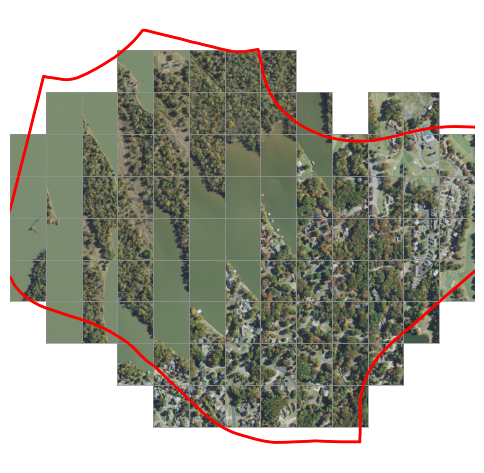

In [179]:
plot_block_images(blocks_df.sample(1))

Total of 1 scenes


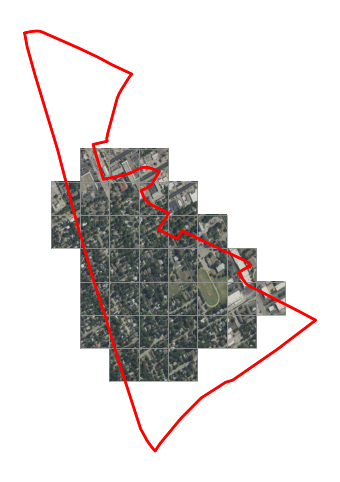

In [180]:
plot_block_images(blocks_df.sample(1))

Total of 3 scenes


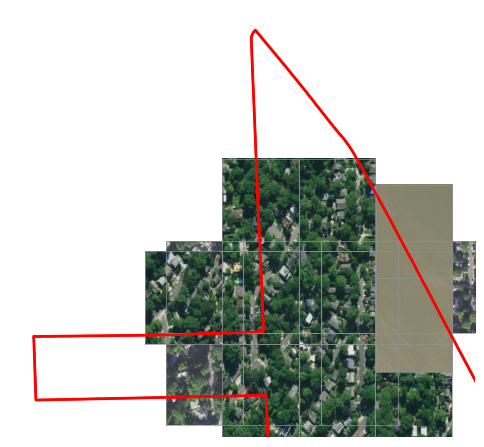

In [181]:
# get block with highest mhi
plot_block_images(blocks_df.sort_values("mhi", ascending=False).head(1))

Total of 2 scenes


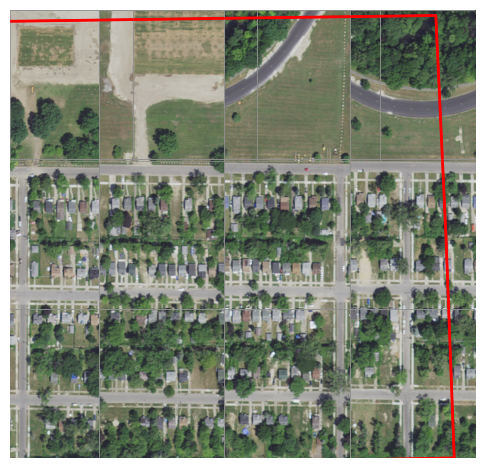

In [183]:
plot_block_images(blocks_df.sort_values("mhi").head(1))